In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

Key Terms:
- vector
- matrix
- dot product
- matrix multiplication
- transpose
- (psuedo)inverse
- Identity Matrix

Replicating the setup from the hallquist paper, and some of chris's code, I've set up some conditions to test whether pulling other regressors _after_ performing nonaggressive denoising is different from pulling other regressors _before_ performing nonaggressive denoising.

In [76]:
# number of timepoints
tp = 200
# create array that contains 200 elements
ix = np.arange(tp)
 
# 0.2 hz
signal1 = np.sin(2*np.pi*ix*(4/tp))
# 0.035 hz
signal2 = np.sin(2*np.pi*ix*(7/tp))
# .11 hz (to be pulled out by ica-aroma)
noise1 = np.cos(2*np.pi*ix*(22/tp))
# .25 hz (to be pulled out by ica-aroma)
noise2 = np.cos(2*np.pi*ix*(50/tp))

signal_tot = signal1 + signal2
noise_tot = noise1 + noise2

bold = signal_tot + noise_tot

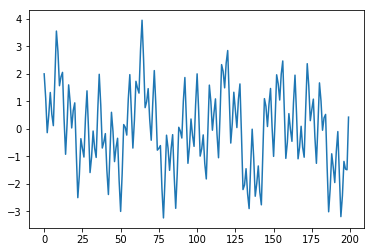

In [77]:
plt.plot(bold)

In [78]:
# noise from csf
csf1 = np.cos(2*np.pi*ix*(12/tp))
csf2 = np.cos(2*np.pi*ix*(40/tp))
csf3 = np.cos(2*np.pi*ix*(60/tp))
csf4 = np.cos(2*np.pi*ix*(80/tp))

# adding in noise component to make the csf regressor colinear with current noise
csf_tot = 0.8*csf1 + 0.6*csf2 + 0.4*csf3 + 0.2*csf4 + noise1
csf_bold = bold + csf_tot

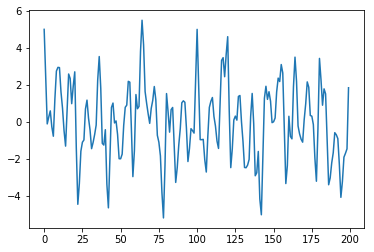

In [79]:
plt.plot(csf_bold)

$$
N = np.stack((noise1, noise2), axis=1) \\
S = noisemap \\
M = maps \\
U = unmixMatrix \\
X = design \\
Y = csf_{bold} \\
R = nonagg_{res} \\
Y_{clean} = bold_{nonagg}
$$

$$
U = (X^TX)^{-1}X^T
$$

$$
M = UY
$$

$$
S = U[3:]
$$

$$
R = NS
$$

$$
Y_{clean} = Y - R
$$

In [80]:
# non-aggresive denoising
design = np.ones((tp, 5))
design[:, 1] = signal1
design[:, 2] = signal2
design[:, 3] = noise1
design[:, 4] = noise2

unmixMatrix = np.linalg.pinv(design)
maps = np.dot(unmixMatrix, csf_bold)

noisemap = maps[3:]

nonagg_res = np.dot(np.stack((noise1, noise2), axis=1), noisemap)
bold_nonagg = csf_bold - nonagg_res

In [81]:
maps.shape

(5,)

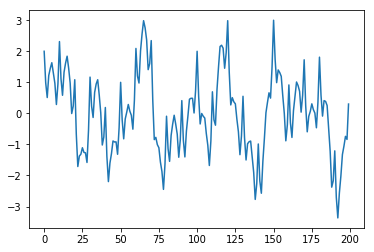

In [82]:
# non-aggressively denoised data
plt.plot(bold_nonagg)

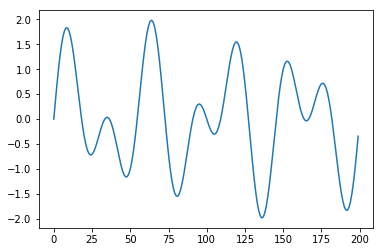

In [83]:
# the gold standard (ground truth of what we are trying to reach)
plt.plot(signal_tot)

In [84]:
# apply the same regression to the csf component
# same as extracting csf after nonaggressive denoising
csf_tot_clean = csf_tot - nonagg_res

# make design matrices for "cleaned" csf and non-cleaned csf
csf_tot_clean_des = np.stack((np.ones(tp), csf_tot_clean), axis=1)

csf_tot_des = np.stack((np.ones(tp), csf_tot), axis=1)

$pinv(X) = (X^TX)^{-1}X^T$

$B = (X^TX)^{-1}X^TY$

$\hat{Y} = Y - XB$

$\hat{Y} = Y - X(X^TX)^{-1}X^TY$

$\hat{Y} = Y - X(X^TX)^{-1}X^TY$

In [85]:
csf_tot_clean_res = np.dot(csf_tot_clean_des, np.dot(np.linalg.pinv(csf_tot_clean_des), bold_nonagg))
# remove the csf_tot_clean residual
csf_clean_regr_bold = bold_nonagg - csf_tot_clean_res

csf_tot_res = np.dot(csf_tot_des, 
                     np.dot(np.linalg.pinv(csf_tot_des), bold_nonagg))
# remove the csf_tot uncleaned residual
csf_tot_regr_bold = bold_nonagg - csf_tot_res

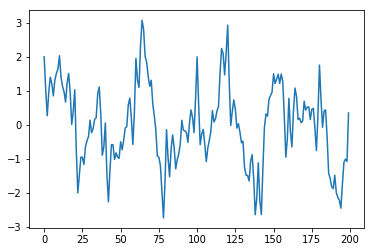

In [86]:
plt.plot(csf_clean_regr_bold)

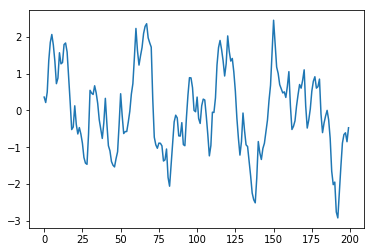

In [87]:
plt.plot(csf_tot_regr_bold)

In [88]:
# how correlated is the ground truth with the cleaned csf?
np.corrcoef(signal_tot, csf_clean_regr_bold)

array([[1.        , 0.85280287],
       [0.85280287, 1.        ]])

In [89]:
# how correlated is the ground truth with the csf
np.corrcoef(signal_tot, csf_tot_regr_bold)

array([[1.        , 0.88640526],
       [0.88640526, 1.        ]])

In [1]:
from scipy.signal import periodogram

(1e-31, 1000.0)

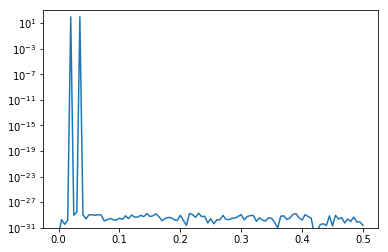

In [28]:
f0, Pxx_den0 = periodogram(signal_tot)
plt.semilogy(f0, Pxx_den0)
plt.ylim([1e-31, 1e3])

(1e-31, 1000.0)

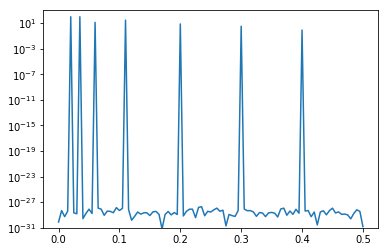

In [29]:
f1, Pxx_den1 = periodogram(csf_tot_regr_bold)
plt.semilogy(f1, Pxx_den1)
plt.ylim([1e-31, 1e3])

(1e-31, 1000.0)

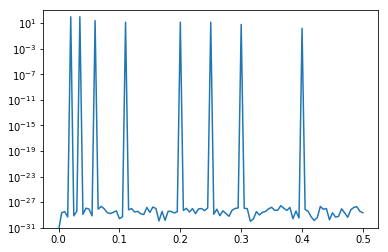

In [30]:
f2, Pxx_den2 = periodogram(csf_clean_regr_bold)
plt.semilogy(f2, Pxx_den2)
plt.ylim([1e-31, 1e3])

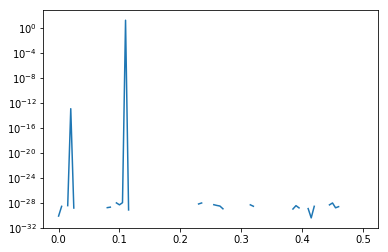

In [39]:
delta_pxx = Pxx_den1 - Pxx_den2
plt.semilogy(f2, delta_pxx)

In [42]:
delta_pxx

array([ 7.65441597e-31,  2.74298748e-29, -2.80463943e-29,  3.56956289e-29,
        1.13686838e-13,  1.47854997e-29, -2.47219388e-29,  4.26325641e-14,
       -9.79661829e-30, -9.91589663e-29, -2.22591459e-30,  9.75246193e-30,
       -1.17768595e+01,  3.92739171e-29, -1.42619684e-28, -8.47092928e-29,
        1.70294736e-29,  2.03752328e-29, -3.40244277e-30,  9.79380608e-29,
        4.80179633e-29,  1.05627374e-28,  1.56895661e+01,  7.32888589e-30,
       -1.00122386e-28, -2.30567228e-29, -7.56818012e-30, -2.25327402e-30,
        1.03889354e-29, -1.28791052e-28, -1.75997746e-29, -1.47836694e-28,
       -6.59415657e-29,  1.14662830e-29, -3.59166222e-29,  1.06352795e-29,
       -1.74544349e-30, -2.57577370e-29,  3.77813972e-30, -2.02148500e-29,
       -6.62448347e+00, -4.45031186e-29, -7.25049919e-29,  5.13832332e-29,
       -1.79693884e-29, -1.29658103e-29,  6.59044594e-29,  9.47829454e-29,
       -3.99177464e-29, -9.20297765e-29, -1.40625000e+01,  5.03609545e-29,
        3.83889041e-29,  

In [166]:
clean_collector = []
unclean_collector = []
for _ in range(1000):
    signal1 = np.random.rand(200)
    signal2 = np.random.rand(200)
    
    noise1 = np.random.rand(200)
    noise2 = np.random.rand(200)
    
    csf = np.random.rand(200)
    
    
    bold = signal1 + signal2 + noise1 + noise2 + csf
    
    # non-aggresive denoising
    design = np.ones((200, 5))
    design[:, 1] = signal1
    design[:, 2] = signal2
    design[:, 3] = noise1
    design[:, 4] = noise2

    unmixMatrix = np.linalg.pinv(design)
    maps = np.dot(unmixMatrix, bold)

    noisemap = maps[3:]

    nonagg_res = np.dot(np.stack((noise1, noise2), axis=1), noisemap)
    bold_nonagg = bold - nonagg_res
    
    # apply the same regression to the csf component
    # same as extracting csf after nonaggressive denoising
    csf_clean = csf - nonagg_res

    # make design matrices for "cleaned" csf and non-cleaned csf
    csf_clean_des = np.stack((np.ones(200), csf_clean), axis=1)

    csf_des = np.stack((np.ones(200), csf), axis=1)
    
    csf_clean_res = np.dot(csf_clean_des, np.dot(np.linalg.pinv(csf_clean_des), bold_nonagg))
    # remove the csf_tot_clean residual
    csf_clean_regr_bold = bold_nonagg - csf_clean_res

    csf_res = np.dot(csf_des, np.dot(np.linalg.pinv(csf_des), bold_nonagg))
    # remove the csf_tot uncleaned residual
    csf_regr_bold = bold_nonagg - csf_res
    
    # signal total
    signal_tot = signal1 + signal2
    
    clean_collector.append(np.corrcoef(signal_tot, csf_clean_regr_bold))
    
    unclean_collector.append(np.corrcoef(signal_tot, csf_regr_bold))
    
display(np.mean(np.array(clean_collector), axis=0))
display(np.mean(np.array(unclean_collector), axis=0))

array([[1.        , 0.99754949],
       [0.99754949, 1.        ]])

array([[1.        , 0.99754949],
       [0.99754949, 1.        ]])

If the csf is highly co-linear with the noise components, then using the cleaned csf is better. If the csf is largely independent of the noise components, then the raw csf is better.

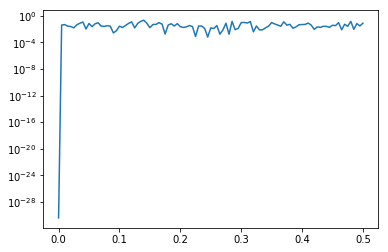

In [61]:
# plt.plot(bold)
f, Pxx_den = periodogram(bold)
plt.semilogy(f, Pxx_den)

## Intro to Vectors/Matrices

**vector**: a quantity with a size and direction.

**A Two Dimensional Vector**

$\vec{a} 
= 
\begin{bmatrix}
    2 \\
    4
\end{bmatrix}$

**A Three Dimensional Vector**

$\vec{b} 
= 
\begin{bmatrix}
    2 \\
    4 \\
    6
\end{bmatrix}$

#### Bold Data
A vector containing bold data contains as many dimensions as there are volumes, so data with 200 volumes is a 200 dimensional vector.

$\vec{c} 
= 
\begin{bmatrix}
    1039 \\
    1024 \\
    \vdots \\
    985
\end{bmatrix}$

There are some cool operations we can do with vectors, like multiply them with the [dot product](https://betterexplained.com/articles/vector-calculus-understanding-the-dot-product/)! 
Be careful, this is not the same as a cross product, which is not necessary to know for what we are working on today.
To understand the dot product, we will dot two 3D vectors, (but the principle holds for 200D vectors as well, like our bold data)


$\vec{v} = 
\begin{bmatrix}
    3 \\
    1 \\
    7 
\end{bmatrix}
$

$
\vec{w} = 
\begin{bmatrix}
    5 \\
    2 \\
    4 
\end{bmatrix}
$

$
\vec{v} \cdot \vec{w} = (3*5) + (1*2) + (7*4) = 15 + 2 + 28 = 45
$

Dot products are really nice, but when we are dealing with bold data, we get a vector for each voxel, which accumulates into a large matrix, how can we do a dot product with a matrix?

3 x 2 matrix

$
\color{blue}B = 
\begin{bmatrix}
    \color{blue}3 & \color{blue}6 \\
    \color{blue}5 & \color{blue}3 \\
    \color{blue}7 & \color{blue}2 
\end{bmatrix}
$

2 x 3 matrix

$
\color{green}G = 
\begin{bmatrix}
    \color{green}1 & \color{green}2 & \color{green}9 \\
    \color{green}3 & \color{green}4 & \color{green}5
\end{bmatrix}
$

3 x 3 matrix

$
\color{blue}B \times \color{green}G =
\begin{bmatrix}
    a & b & c \\
    d & e & f \\
    g & h & i
\end{bmatrix}
$

$
a = (\color{blue}3 \times \color{green}1) + (\color{blue}6 \times \color{green}3) = 21
$

$
b = (\color{blue}3 \times \color{green}2) + (\color{blue}6 \times \color{green}4) = 30
$

$
c = (\color{blue}3 \times \color{green}9) + (\color{blue}6 \times \color{green}5) = 57
$

$
d = (\color{blue}5 \times \color{green}1) + (\color{blue}3 \times \color{green}3) = 14
$

$
e = (\color{blue}5 \times \color{green}2) + (\color{blue}3 \times \color{green}4) = 22
$

$
f = (\color{blue}5 \times \color{green}9) + (\color{blue}3 \times \color{green}5) = 60
$

$
g = (\color{blue}7 \times \color{green}1) + (\color{blue}2 \times \color{green}3) = 13
$

$
h = (\color{blue}7 \times \color{green}2) + (\color{blue}2 \times \color{green}4) = 22
$

$
i = (\color{blue}7 \times \color{green}9) + (\color{blue}2 \times \color{green}5) = 73
$

$
\color{blue}B \times \color{green}G =
\begin{bmatrix}
    a = (\color{blue}3 \times \color{green}1) + (\color{blue}6 \times \color{green}3) = 21 & b = (\color{blue}3 \times \color{green}2) + (\color{blue}6 \times \color{green}4) = 30 & c = (\color{blue}3 \times \color{green}9) + (\color{blue}6 \times \color{green}5) = 57 \\
    d = (\color{blue}5 \times \color{green}1) + (\color{blue}3 \times \color{green}3) = 14 & e = (\color{blue}5 \times \color{green}2) + (\color{blue}3 \times \color{green}4) = 22 & f = (\color{blue}5 \times \color{green}9) + (\color{blue}3 \times \color{green}5) = 60 \\
    g = (\color{blue}7 \times \color{green}1) + (\color{blue}2 \times \color{green}3) = 13 & h = (\color{blue}7 \times \color{green}2) + (\color{blue}2 \times \color{green}4) = 22 & i = (\color{blue}7 \times \color{green}9) + (\color{blue}2 \times \color{green}5) = 73
\end{bmatrix}
$

Whew, that was a lot of mutliplication, but when we break it down, it's just dot products. 
The 3 rows of $\color{blue}B$ are dotted with the 3 columns of $\color{green}G$, resulting in a 3x3 matrix. 
Can you guess what would happen if you did $\color{green}G \times \color{blue}B$ instead of $\color{blue}B \times \color{green}G$ as we did above?

## Intro to Regression

you all remember your basic line equation, correct? 
$$y = mx + b$$
In the the context of fMRI, $y$ represents our observed BOLD data from the scanner, $x$ represents our design (or in other words our expectation of the general shape of the observed data $y$), and $b$ represents the intercept.
$m$ represents what is traditionally called beta coefficients, scaling $x$ so that it best fits with the observed data $y$.

Now that we have a handle on vectors and matrices, let's replace $y$ and ($b+m$) with the vectors $\vec{y}$ and $\vec{b}$ where the first element in $\vec{b}$ is the intercept and the second element is $m$.
$x$ becomes matrix $X$ where the first column is a column of ones, to model the intercept, and the second column will be what we defined before as the design.
$$\vec{y} = \vec{b}X$$
Let's define $\vec{y}$ and $X$ and give them life (with some numbers)

$
\vec{y} = 
\begin{bmatrix}
    2 \\
    4 \\
    6 \\
    8 \\
    10
\end{bmatrix}
$

$
X = 
\begin{bmatrix}
    1 & 1 \\
    1 & 2 \\
    1 & 3 \\
    1 & 4 \\
    1 & 5
\end{bmatrix}
$

And let's define $\vec{b}$ even though we don't know what values it should have yet.
First we will write it with $b$ and $m$, but then I will use the more traditional notation,
$b_0$ and $b_1$.

Directly from the first equation:
$
\vec{b} = 
\begin{bmatrix}
    b \\
    m
\end{bmatrix}
$

More traditional notation:
$
\vec{b} = 
\begin{bmatrix}
    b_0 \\
    b_1
\end{bmatrix}
$

To be explicit, we are searching for an $m$ that satisfies the following systems of equations.
$$1b_0 + 1b_1 = 2$$
$$1b_0 + 2b_1 = 4$$
$$1b_0 + 3b_1 = 6$$
$$1b_0 + 4b_1 = 8$$
$$1b_0 + 5b_1 = 10$$
In this case it almost trivial to calculate $\vec{b}$.
$\vec{b}$ is equal to $\begin{bmatrix} 0 \\ 2 \end{bmatrix}$ since the intercept is 0 and the best (in this case perfect) $b_1$ to match the observed data is 2.
What if we weren't so lucky to get a perfect match between our design and observed data? (A much more likely scenerio).

Let's redefine $\vec{y}$ to see what happens:

$
\vec{y} = 
\begin{bmatrix}
    2 \\
    3 \\
    7 \\
    8 \\
    13
\end{bmatrix}
$

Well shoot, there doesn't appear to be an $\vec{b}$ that satifies this system of equations:
$$1b_0 + 1b_1 = 2$$
$$1b_0 + 2b_1 = 3$$
$$1b_0 + 3b_1 = 7$$
$$1b_0 + 4b_1 = 8$$
$$1b_0 + 5b_1 = 13$$
Do we give up?
No!
Since we can't recreate $\vec{y}$ perfectly, we will settle for an estimate of $\vec{b}$ that scales $X$ to match $\vec{y}$ as closely as possible, and we will denote this imperfect (but as close as possible) estimate of $\vec{b}$ with a circumflex, or a hat, and call it '$\vec{b}$ hat' denoted as $\hat{\vec{b}}$
$$\vec{y} = \hat{\vec{b}}X$$
We can use some tricks from matrices to get an answer that is as close as possible using ordinary least squares.
We want to solve for $\vec{b}$, so let's first just switch the terms around so that $m$ is on the left.
$$\hat{\vec{b}}X = \vec{y}$$
We want to get rid of $X$ on the left, but sadly we can't just divide off matrices (or another way to think of it is multiply the reciprocal of $X$), so we have to look for some other tools in our matrix toolkit. 
Luckily, there is one such tool!
If we can multiply $X$ by its inverse, then we've essentially removed it from the left side of the equation.
For a short definition, an inverse of any matrix $A$, denoted by $A^{-1}$ is a matrix that satifies the following equality:
$$AA^{-1} = 
\begin{bmatrix}
    1 & \cdots & 0 \\
    0 & \ddots & 0 \\
    0 & \cdots & 1
\end{bmatrix}
$$
where the resulting square matrix only has 1's down the diagnal, and zeros everywhere else.
This is called the identity matrix, and any matrix multiplied with the identity matrix is itself.
However, taking an inverse requires $X$ to be a square matrix, and if we experimentalists worth our weight in salt, we won't have anywhere near as many columns (parameters we are trying to measure) as rows (volumes of BOLD data), so we have to take a psuedo-inverse.
A psuedo-inverse starts with taking the multiplying the transpose of $X$ on either side denoted as $X^T$.
$$
X^T = 
\begin{bmatrix}
    1 & 1 & 1 & 1 & 1 \\
    1 & 2 & 3 & 4 & 5
\end{bmatrix}
$$

which results in:
$$ \hat{\vec{b}}X^TX = X^TY $$

where $X^TX$ is:
$$
X^TX = 
\begin{bmatrix}
    5 & 15 \\
    15 & 55
\end{bmatrix}
$$
Now any square symmetric matrix is invertible, so now we can calculate the inverse of $X^TX$ denoted as $(X^TX)^{-1}$:
$$
(X^TX)^{-1} = 
\begin{bmatrix}
    11/10 & -3/10 \\
    -3/10 & 1/10
\end{bmatrix}
$$

Which we can confirm gives us the identity matrix by mutltiplying $X^TX$ with $(X^TX)^{-1}$:
$$
(X^TX)^{-1}X^TX = 
\begin{bmatrix}
    (11/10 \times 5) + (-3/10 \times 15) = 1 & (11/10 \times 15) + (-3/10 \times 55) = 0\\
    (11/10 \times 15) + (-3/10 \times 55) = 0 & (-3/10 \times 15) + (1/10 \times 55) = 1
\end{bmatrix}
$$

Now we can multiply $(X^TX)^{-1}$ on both sides of the equation:
$$\hat{\vec{b}}(X^TX)^{-1}X^TX = (X^TX)^{-1}X^TY$$

which $(X^TX)^{-1}X^TX$ becomes the identity matrix $I$:
$$\hat{\vec{b}}I = (X^TX)^{-1}X^TY$$

and since the identity matrix multiplied by any matrix, remains that matrix, we can drop $I$:
$$\hat{\vec{b}} = (X^TX)^{-1}X^TY$$

And now we can solve this!
Starting with $(X^TX)^{-1}X^T$, we get:
$$
(X^TX)^{-1}X^T = 
\begin{bmatrix}
    4/5 & 1/2 & 1/5 & -1/10 & -2/5 \\
    -1/5 & -1/10 & 0 & 1/10 & 1/5
\end{bmatrix}  
$$

Which we can multiply that result by $Y$:
$$
(X^TX)^{-1}X^TY = \hat{\vec{b}} =
\begin{bmatrix}
    -3/2 \\
    27/10
\end{bmatrix} 
$$
and to see if the math worked let's graph $\vec{y}$ and the regression line $X\hat{\vec{b}}$

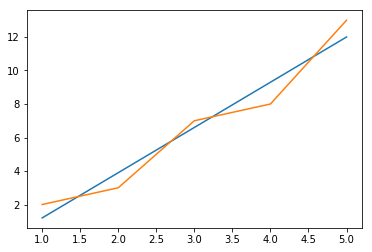

In [58]:
def graph(formula, x_range, y_obs):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)
    plt.plot(x, y_obs)
    plt.show() 

# ordinary least squares regression line
def best_line(x):
    return (27/10) * x - (3/2)

# observed data
y_obs = np.array([2, 3, 7, 8, 13])

graph(best_line, range(1,6), y_obs)

## [Understanding PCA/ICA](https://classroom.udacity.com/courses/ud262/lessons/649069103/concepts/6614385440923)
